In [234]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [235]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

from keras import models
from keras import layers
from keras import optimizers 
from keras import metrics

## Загрузка данных

In [236]:
file_name = "data_new_circles.csv"
num_data = pd.read_csv(file_name)

In [237]:
target = "target"

## Вычисляются веса для классов 
Для несбалансированных данных

In [238]:
pos = num_data[target].mean()
neg = 1 - pos

In [239]:
weight_for_0 = (1 / neg) / 2
weight_for_1 = (1 / pos) / 2

class_weight = {0 : weight_for_0, 1 : weight_for_1}

print(weight_for_0, weight_for_1)

1.0 1.0


In [1]:
# функция делит датасет с сохранением пропорции классов
def sample(data, cut, target):
    return data.groupby(target, group_keys=False).apply(lambda x: x.sample(frac=1/cut))   

In [242]:
def get_train_test_split(data, target, cut, random_state = None):
    num_data_new = sample(data, cut, target)
    
    train, test = train_test_split(num_data_new, test_size=0.2, random_state=random_state) 

    y_train = np.array(train[target])
    y_test = np.array(test[target])

    x_train = np.array(train.drop(columns=[target]))
    x_test = np.array(test.drop(columns=[target]))
    
    return x_train, x_test, y_train, y_test 

In [245]:
input_size = len(num_data.columns) - 1
print(input_size)

2


## Конфигурация сети и дробления данных

In [3]:
# конфигурация сети задаётся здесь: два внутренних слоя и количество последних нейронов
params = [20, 20, 1]

In [247]:
volume = len(num_data)
# объём данных, до которого исходный датасет урезается
data_vol = [volume, 
            # volume/2, 
            # volume/3, 
            # volume / 5, 
            # volume/10, 
            # 30, 
            # 15, 
            # 10, 
            6, 
            2] 
log_cuts = list(map(lambda x: int(volume / x), data_vol))

In [248]:
print("Volume = {},\nCuts are {}".format(volume, log_cuts))
print("Volume of data is {}".format(list(map(lambda x: int(volume / x), log_cuts))))

Volume = 600,
Cuts are [1, 100, 300]
Volume of data is [600, 6, 2]


In [249]:
get_model_directory = lambda series, cut: "models/{}_series/{}_cut/".format(series, cut)
get_model_name = lambda number:  f"m_{number}.h5"

In [251]:
# from keras.optimizers import regularizers

# Функция компилирует модель с заданной конфигурацией 
def make_model(input_size, parameters):
    model = models.Sequential()

    model.add(layers.Dense(parameters[0], activation='relu', input_shape=(input_size,))) # , kernel_regularizer="l2"
    for i in range(1, len(parameters)-1):
        model.add(layers.Dense(parameters[i], activation="relu")) #, kernel_regularizer="l1")
    model.add(layers.Dense(parameters[-1], activation='sigmoid')) # , kernel_regularizer="l1"
    
    model.compile(optimizer=optimizers.Adam(), 
              loss='binary_crossentropy', 
              metrics=["accuracy"]
              )
    
    return model

In [252]:
from keras.callbacks import ModelCheckpoint
# В теле этой функции задаются параметры обучения, чекпоинты
def model_train(model_name, data_split, epochs, random_target=False):
    model = make_model(input_size, params)

    # не используется 
    # checkpoint = ModelCheckpoint(model_name, 
    #     verbose=0, 
    #     monitor='val_accuracy',
    #     save_best_only=True, 
    #     mode='auto'
    # )  

    early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=10,
    mode='auto',
    restore_best_weights=True)

    x_train, x_test, y_train, y_test = data_split

    if random_target:
        y_train = np.random.randint(2, size = len(y_train))
        y_test = np.random.randint(2, size = len(y_test))  

    history = model.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=min(32, len(x_train)),  
                    validation_data=(x_test, y_test), 
                    class_weight=class_weight, 
                    callbacks = [early_stopping]) 
    return history, model

In [253]:
import datetime 
# для логов
def log_preamble(log_file_name):
    global tries, epochs, series, file_name
    time_stamp = datetime.datetime.now()

    with open(log_file_name, "a") as log_file:
        log_file.write(f"\n\nExecuted on time is {datetime.datetime.now()}\n")
        log_file.write(f"Tries: {tries}, epochs: {epochs}, series = {series}\n")
        log_file.write(f"Data file is {file_name}\n")
        log_file.write(f"Network configuration is {params}\n")
    return time_stamp

def log_final(log_file_name, time_stamp):
    time_stamp_new = datetime.datetime.now()
    with open(log_file_name, "a") as log_file:
        log_file.write(f"Finished successfully at {time_stamp_new}\n")
        log_file.write(f"Total time = {(time_stamp_new - time_stamp).total_seconds()}\n")

## Обучение

In [4]:
# путь к файлу модели
model_name = lambda series_num, cut_val, model_num: get_model_directory(series_num, cut_val) + get_model_name(model_num)

In [255]:
series = [17] # набор серий. в каждой серии модели обучаются на одном и том же датасете
tries = 15 # количество моделей в каждой серии
epochs = 30

histories = [[[] for _ in log_cuts] for _ in series] # для сохранения истории обучения 

log_file = "model_log.txt"
t = log_preamble(log_file)

for i, s in enumerate(series):
    for cut_number, cut in enumerate(log_cuts):
        split = get_train_test_split(num_data, target, cut)
        for number in range(tries):
            model_name_current = model_name(s, cut, number)
            history, model = model_train(model_name_current, split, epochs) 
            
            model.save(model_name_current)
            histories[i][cut_number].append(history)

log_final(log_file, t)

Epoch 1/30


15/15 [==============================] - 1s 14ms/step - loss: 0.6670 - accuracy: 0.5125 - val_loss: 0.6717 - val_accuracy: 0.4917
Epoch 2/30
15/15 [==============================] - 0s 5ms/step - loss: 0.6391 - accuracy: 0.6042 - val_loss: 0.6482 - val_accuracy: 0.6917
Epoch 3/30
15/15 [==============================] - 0s 4ms/step - loss: 0.6170 - accuracy: 0.7271 - val_loss: 0.6307 - val_accuracy: 0.6750
Epoch 4/30
15/15 [==============================] - 0s 4ms/step - loss: 0.5991 - accuracy: 0.7250 - val_loss: 0.6142 - val_accuracy: 0.6833
Epoch 5/30
15/15 [==============================] - 0s 4ms/step - loss: 0.5824 - accuracy: 0.7375 - val_loss: 0.5991 - val_accuracy: 0.7000
Epoch 6/30
15/15 [==============================] - 0s 4ms/step - loss: 0.5672 - accuracy: 0.7542 - val_loss: 0.5839 - val_accuracy: 0.7167
Epoch 7/30
15/15 [==============================] - 0s 4ms/step - loss: 0.5523 - accuracy: 0.7542 - val_loss: 0.5686 - val_accuracy: 0.7250
Epoch 8/30
15/15 [============

In [256]:
def display_loss_graph(history):
    history_dict = history.history
    loss_values = history_dict['loss'] 
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values)+1)
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def display_accuracy_graph(history):
    history_dict = history.history
    acc = history_dict["accuracy"]
    val_acc = history_dict['val_accuracy']
    epochs = range(1, len(acc)+1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [257]:
import pickle
import os

# сохраняет все данные о серии
for s in range(len(series)):
    for i, cut in enumerate(log_cuts):
        for x in range(tries):
            filename = './histories/{}_series/{}_cut/m_{}'.format(s, i, x)

            os.makedirs(os.path.dirname(filename), exist_ok=True)
            with open(filename, "wb") as file:
                pickle.dump(histories[s][i][x], file)

In [ ]:
# для ранжировки моделей по точности
accuracy_score = [[[-1 for _ in range(tries)] for _ in log_cuts] for _ in series]

In [259]:
for s in range(len(series)):
    for i, cut in enumerate(log_cuts):
        for x in range(tries):
            history_dict = histories[s][i][x].history["val_accuracy"]
            accuracy_score[s][i][x] = np.max(history_dict)

{'whiskers': [<matplotlib.lines.Line2D at 0x1cc2b0036a0>,
 'caps': [<matplotlib.lines.Line2D at 0x1cc2b0019f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1cc2b002440>,
 'medians': [<matplotlib.lines.Line2D at 0x1cc2b001ea0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1cc2b001360>,
 'means': []}

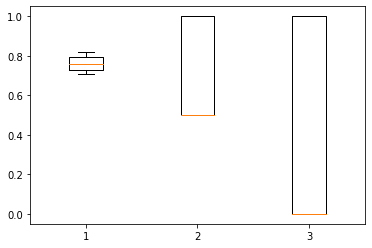

In [260]:
plt.boxplot(accuracy_score[0])

In [261]:
acc_data = {}

In [262]:
for s in range(len(series)):
    for i in range(len(log_cuts)):
        for x in range(tries):
            acc_data[(s, i, x)] = accuracy_score[s][i][x]

In [263]:
with open("acc_dict" + str(series), "wb") as file:
    pickle.dump(acc_data, file)

## Облако точек - топологическая сложность сети

In [ ]:
# Данные нормализуются перед обучением, 
# тестовые точки выбираются в количестве N = 400 штук в квадрате и нормализуются.  

nx, ny = (20, 20)

x = np.linspace(0, 1, nx)

y = np.linspace(0, 1, ny)
xv, yv = np.meshgrid(x, y)

In [265]:
points = np.array([(xv[i // 20, i % 20], yv[i // 20, i%20]) for i in range(400)])

In [266]:
norm_points = (points - points.mean()) / points.std()

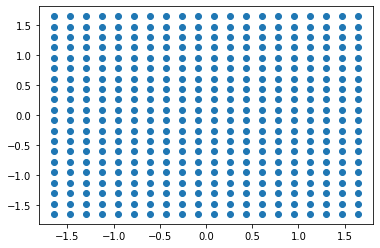

In [268]:
plt.scatter(norm_points[:, 0], norm_points[:, 1])

In [ ]:
# загружается произвольная модель
test_model = models.load_model(model_name(16, 1, 1))
test_model.compile()

In [274]:
pred = test_model.predict(norm_points)

13/13 [==============================] - 0s 1ms/step


In [276]:
target = (pred > 1/2)

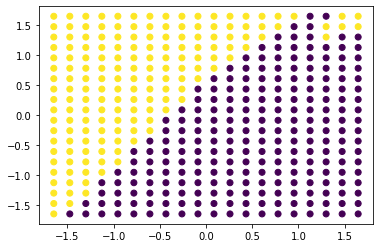

In [281]:
plt.scatter(norm_points[:, 0], norm_points[:, 1], c=target)

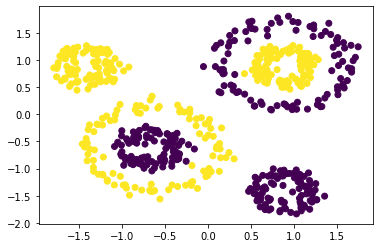

In [279]:
plt.scatter(num_data["0"], num_data["1"], c=num_data["target"])

In [280]:
# def output_homology(model):
#     # the data the model is trained on should be normalised
#     vals = model.predict(points) 
# ...